## **SPAM CLASSIFIER**

***Problem Statement: Build a spam classifier***  
• Download examples of spam and ham from Apache SpamAssassin’s public datasets: 
https://spamassassin.apache.org/old/publiccorpus/
• Unzip the datasets and familiarize yourself with the data format.  
• Split the datasets into a training set and a test set.  
• Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word.  
You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).  
Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.


**Building a Spam classifier**

In machine learning point of view when we choose spam filtering approach, we can see classification problem. Here we classify email as spam or not spam (Ham) which depends on the features. But, in our point of view the features are the count of each word in the email. Training and Testing are the two modes which a machine learning system operates. In training the AI system is a given labelled data from the training data set. But in our project large set of emails are the labelled training data which is labeled spam or not spam (Ham). In the training process the classifiers prepare from the training data shows the interlink between the email and its label. But in the testing process an unlabeled data is given to the machine learning system. These data are the emails without the spam/ham label. The classifier in the testing shows us either it is spam or ham which depends on the features of an email.

Build a model to classify email as spam or ham. First, download examples of spam and ham from Apache SpamAssassin’s public datasets and then train a model to classify email.



**1. Fetching the Data**

In [3]:
import os
import tarfile
import urllib
import urllib.request; urllib.request.urlopen

DOWNLOAD_MAILS = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_MAILS + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_MAILS + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("dataset", "spams")


def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
          urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

fetch_spam_data()


**2. Loading few emails**

In [4]:
HAM_MAILS = os.path.join(SPAM_PATH, "easy_ham")
SPAM_MAILS = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_MAILS)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_MAILS)) if len(name) > 20]
     

In [5]:
len(ham_filenames)

2500

In [6]:
len(spam_filenames)

500

**3. Using python's email module to parse these emails(this handles headers, encoding, and so on)**

In [7]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [8]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

**4. Look at one example of ham and one example of spam, to get a feel of what the data looks like**

In [9]:
print(ham_emails[5].get_content().strip())

> I just had to jump in here as Carbonara is one of my favourites to make and 
> ask 
> what the hell are you supposed to use instead of cream? 

Isn't it just basically a mixture of beaten egg and bacon (or pancetta, 
really)? You mix in the raw egg to the cooked pasta and the heat of the pasta 
cooks the egg. That's my understanding.

Martin

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [10]:
print(spam_emails[3].get_content().strip())

##################################################
#                                                #
#                 Adult Club                     #
#           Offers FREE Membership               #
#                                                #
##################################################

>>>>>  INSTANT ACCESS TO ALL SITES NOW
>>>>>  Your User Name And Password is.
>>>>>  User Name: zzzz@spamassassin.taint.org
>>>>>  Password: 760382

5 of the Best Adult Sites on the Internet for FREE!
---------------------------------------
NEWS 08/18/02
With just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New
Members. Are you one of them yet???
---------------------------------------
Our Membership FAQ

Q. Why are you offering free access to 5 adult membership sites for free?
A. I have advertisers that pay me for ad space so you don't have to pay for membership.

Q. Is it true my membership is for life?
A. Absolutely you'll never have to pay a cen

**5. Some emails are actually multipart, with images and attachments (which can have their own attachments). Look at the various types of structures we have**

In [11]:
def email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [12]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = email_structure(email)
        structures[structure] += 1
    return structures

In [13]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [15]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of 
HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In 
short, it seems that the email structure is useful information to have.

**6. Taking look at email headers**

In [16]:
for header, value in spam_emails[1].items():
    print(header,":",value)


Return-Path : <ilug-admin@linux.ie>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id A7FD7454F6	for <zzzz@localhost>; Thu, 22 Aug 2002 08:27:38 -0400 (EDT)
Received : from phobos [127.0.0.1]	by localhost with IMAP (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:27:38 +0100 (IST)
Received : from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MCJiZ06043 for    <zzzz-ilug@jmason.org>; Thu, 22 Aug 2002 13:19:44 +0100
Received : from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org    (8.9.3/8.9.3) with ESMTP id NAA29323; Thu, 22 Aug 2002 13:18:52 +0100
Received : from email.qves.com ([67.104.83.251]) by lugh.tuatha.org    (8.9.3/8.9.3) with ESMTP id NAA29282 for <ilug@linux.ie>; Thu,    22 Aug 2002 13:18:37 +0100
X-Authentication-Warning : lugh.tuatha.org: Host [67.104.83.251] claim

There's probably a lot of useful information in there, such as the sender's email address,  but we will just focus on the Subject 
header

In [17]:
spam_emails[1]["Subject"]

'[ILUG] Guaranteed to lose 10-12 lbs in 30 days 10.206'

**7. Split data into a training set and a test set**

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)[:]
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))[:]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



**8. Learning too much about the data**

Start writing the preprocessing functions. First, we will need a function to convert 
HTML to plain text. Arguably the best way to do this would be to use the great 
BeautifulSoup library, but I would like to avoid adding another dependency to this 
project, so let's hack a quick & dirty solution using regular expressions. The function 
first drops the <head> section, then converts all <a> tags to the word HYPERLINK, then 
it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces 
multiple newlines with single newlines, and finally it unescapes html entities (such as &gt; or &nbsp;)

In [20]:
#ToDo
#- Convert HTML to plain text (using BS4 or regex)
import re 
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

html_spam_emails = [email for email in X_train[y_train==1]
                    if email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [21]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

**9. Writing a function that takes an email as input and returns its content as plain text**

In [22]:
#Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)


In [23]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


**9. Let's do more text preprocessing, technically-> stemming**

In [24]:
import nltk
stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive","Technology","Convulated"):
        print(word, "-->", stemmer.stem(word))

Computations --> comput
Computation --> comput
Computing --> comput
Computed --> comput
Compute --> comput
Compulsive --> compuls
Technology --> technolog
Convulated --> convul


**11. We will also need a way to replace URLs with the word "URL". For this, we could use hard core regular expressions but we will just use the urlextract library. You can install it with the following command**

In [25]:
! pip install urlextract

In [26]:
import urlextract
from urlextract import URLExtract
urlextractor = urlextract.URLExtract()
#try
    
urlextractor = urlextract.URLExtract()
print(urlextractor.find_urls("Will it detect github.com and https://www.youtube.com/results?search_query=little+engineers+explainations"))

   

['github.com', 'https://www.youtube.com/results?search_query=little+engineers+explainations']


**12. Now put all this together into a transformer that we will use to convert emails to word counters.**

**13. We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's split() method, which uses whitespaces for word boundaries.**

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class dopeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email)

            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', str(text))#regexIStough!!
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            if self.replace_urls and urlextractor is not None:
                urls = list(set(urlextractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)  
    
    def fit(self, X, y=None):
        return self
            

In [28]:
sampleX = X_train[:2]
sampleXwordcount = dopeTransformer().fit_transform(sampleX)
print(sampleXwordcount)

[Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'R': 1})
 Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'by': 3, 'jefferson': 2, 'I': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'to': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'http': 1, 'www': 1, 'postfun': 1, 'com': 1, 'pfp': 1, 'worboi': 1, 'html': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'To': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'E': 1, 'remsbu

**14. Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose fit() method will build the vocabulary (an ordered list of the most common words) and whose transform() method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.**

In [29]:
from scipy.sparse import csr_matrix

class dopeVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocab_size =1000):
        self.vocab_size = vocab_size
            
    def fit(self, X, y=None):#builds the vocabulary (an ordered list of the most common words)
        countT = Counter()
        for word_count in X:
            for word, count in word_count.items():
                countT[word]+=min(count, 10)
        mostCommon = countT.most_common()[:self.vocab_size]
        self.mostCommon = mostCommon
        self.vocab = {word: index + 1 for index, (word, count) in enumerate(mostCommon)}
        return self
    
    def transform(self, X, y=None):
        R=[]; C=[]; Data=[]
        for r, word_count in enumerate(X):
            for word, count in word_count.items():
                R.append(r)
                C.append(self.vocab.get(word,0))
                Data.append(count)
        return csr_matrix((Data, (R, C)), shape=(len(X), self.vocab_size + 1))

In [30]:
sampleVectorX = dopeVectorTransformer(vocab_size=5)
sampleVectors = sampleVectorX.fit_transform(sampleXwordcount)
print(sampleVectors)
sampleVectors.toarray()
print(sampleVectorX.vocab)

  (0, 0)	6
  (1, 0)	115
  (1, 1)	11
  (1, 2)	9
  (1, 3)	8
  (1, 4)	3
  (1, 5)	3
{'the': 1, 'of': 2, 'and': 3, 'all': 4, 'christian': 5}


**15. Train our first spam classifier! Let's transform the whole dataset**

In [31]:
from sklearn.pipeline import Pipeline

pre_processing = Pipeline([("email_to_word_count", dopeTransformer()),
                          ("wordcount_to_vector", dopeVectorTransformer()),
                          ])
X_train_transformed = pre_processing.fit_transform(X_train)

In [51]:
print(X_test.shape)
print(X_train_transformed.shape)
print(y_train.shape)
print(y_test.shape)

(600, 1001)
(2400, 1001)
(2400,)
(600,)


In [52]:
X_test.dtype

dtype('int64')

In [53]:
X_test[5]

<1x1001 sparse matrix of type '<class 'numpy.int64'>'
	with 73 stored elements in Compressed Sparse Row format>

**15. Print out the precision/recall we get on the test set**

# Logistic Regression

Logistic regression is basically a supervised classification algorithm. In a classification problem, the target variable(or output), y, can take only discrete values for a given set of features(or inputs), X.  
 The model builds a regression model to predict the probability that a given data entry belongs to the category numbered as “1”. Just like Linear regression assumes that the data follows a linear function, Logistic regression models the data using the sigmoid function.

In [41]:
from sklearn.linear_model import LogisticRegression
#create a model object
classifier = LogisticRegression()

#train the model object
classifier.fit(X_train_transformed,y_train)

Y_pred=classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


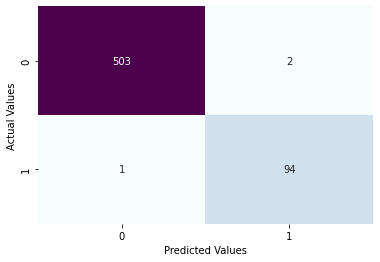

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       505
           1       0.98      0.99      0.98        95

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       1.00      0.99      1.00       600

Accuracy of the model:  0.995


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cfm=confusion_matrix(y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='BuPu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


print("Classification report:")

print(classification_report(y_test,Y_pred))

acc=accuracy_score(y_test,Y_pred)
print("Accuracy of the model: ",acc)


*   The precision & recall was good with LogisticRegression.
*   The Accuracy of the model was 0.995

*   TYPE I & TYPE II errors were also less which is good as very less values were misclassified.







# Support Vector Machine

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

In [45]:
from sklearn.svm import SVC
svc_model=SVC(kernel='rbf',C=20,gamma=0.01)
svc_model.fit(X_train_transformed,y_train)
Y_pred=svc_model.predict(X_test)
#print(list(Y_pred))

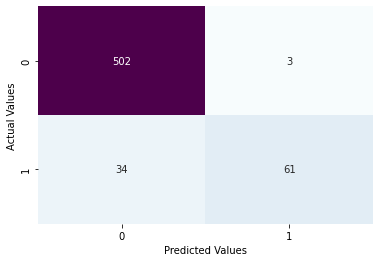

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       505
           1       0.95      0.64      0.77        95

    accuracy                           0.94       600
   macro avg       0.94      0.82      0.87       600
weighted avg       0.94      0.94      0.93       600

Accuracy of the model:  0.9383333333333334


In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cfm=confusion_matrix(y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='BuPu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


print("Classification report:")

print(classification_report(y_test,Y_pred))

acc=accuracy_score(y_test,Y_pred)
print("Accuracy of the model: ",acc)



*   The precision of the SVM model was considerable but recall of both the classes 0 & 1 had slight difference.
*   Recall is most important thing to look for as this can show biasness of values towards a particular class.


*   Accuracy of the model is 0.9383333333333334
*   TYPE II error was more as it can be bad for the model as more values were misclassified into TYPE II.





# Naive Bayes

Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but a family of algorithms where all of them share a common principle, i.e. every pair of features being classified is independent of each other.

In [49]:
from sklearn.naive_bayes import GaussianNB

model_NB = GaussianNB()

#fit the model on the data and predict the values
model_NB.fit(X_train_transformed.toarray(),y_train)

Y_pred = model_NB.predict(X_test.toarray())
#print(Y_pred)

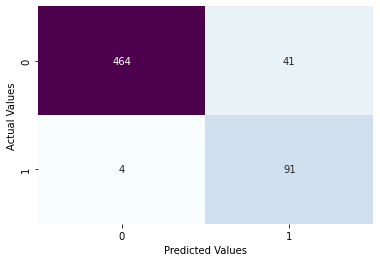

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       505
           1       0.69      0.96      0.80        95

    accuracy                           0.93       600
   macro avg       0.84      0.94      0.88       600
weighted avg       0.94      0.93      0.93       600

Accuracy of the model:  0.925


In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cfm=confusion_matrix(y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='BuPu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


print("Classification report:")

print(classification_report(y_test,Y_pred))

acc=accuracy_score(y_test,Y_pred)
print("Accuracy of the model: ",acc)



*   The precision & recall of the Naive Bayes were considerably good.
*   The Accuracy of the model - 0.925


*   TYPE II error was very few whereas TYPE I error was more in this model






### Conclusion

The models used by us for classification of the problem are -
1. Logistic Regression
2. Support Vector Machine(SVM)
3. Naive Bayes

In Logistic Regression, we can observe that Accuracy(0.995) was quite good as compared to the other models.  
The precision, recall values of the Logistic Regression were also considerably good.  
Even the TYPE I & TYPE II error were low, which means only few of the values were misclassified.  
So, we can say that Logistic Regresion performed good with the data provided to us.